### S10 T01: Aprenentage Supervisat

Exercicis 1, 2, 3, 4

- Crea almenys tres models de __classificació__ diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

- Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confusió i d’altres mètriques més avançades.

- Entrena’ls utilitzant els diferents paràmetres que admeten.

- Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

#### Loading Data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics #for accuracy calculation
import re
import warnings
warnings.filterwarnings('ignore')

# Importing dataset
df = pd.read_csv('DelayedFlights.csv')

#### Pre-Processing

In [2]:
df[:3]

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(1936758, 30)

In [4]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

Just keep the features we want, drop the rest

In [5]:
df.drop(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'AirTime', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)

We create a new column to consider if a flight is delayed or not

In [6]:
df['Delayed'] = df['ArrDelay'] > 0
df['Delayed'] = df['Delayed'].astype(int) #boolean to 0 y 1

In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DayOfWeek          int64  
 1   DepTime            float64
 2   CRSDepTime         int64  
 3   ArrTime            float64
 4   CRSArrTime         int64  
 5   ActualElapsedTime  float64
 6   CRSElapsedTime     float64
 7   ArrDelay           float64
 8   DepDelay           float64
 9   CarrierDelay       float64
 10  WeatherDelay       float64
 11  NASDelay           float64
 12  SecurityDelay      float64
 13  LateAircraftDelay  float64
 14  Delayed            int64  
dtypes: float64(11), int64(4)
memory usage: 221.6 MB


As it is a large dataset, we better work with a sample of 10%

In [8]:
population_size = len(df)
sample_size = int(population_size * 0.1)
np.random.seed(42) # for same random results 
df = df.sample(sample_size)

Find and replace missing values

In [9]:
df.isnull().sum()

DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                708
CRSArrTime               0
ActualElapsedTime      840
CRSElapsedTime          26
ArrDelay               840
DepDelay                 0
CarrierDelay         68739
WeatherDelay         68739
NASDelay             68739
SecurityDelay        68739
LateAircraftDelay    68739
Delayed                  0
dtype: int64

In [10]:
df1 = df.fillna(0) # 0: to not loose data, df1: to stick with the clean dataset
df1.head(3)

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
1782417,6,1805.0,1755,2146.0,2035,281.0,220.0,71.0,10.0,71.0,0.0,0.0,0.0,0.0,1
512712,7,2120.0,1200,2241.0,1333,81.0,93.0,548.0,560.0,543.0,0.0,0.0,0.0,5.0,1
447137,1,1731.0,1710,1819.0,1810,48.0,60.0,9.0,21.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
df1.shape

(193675, 15)

In [12]:
df1.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'ActualElapsedTime', 'CRSElapsedTime', 'ArrDelay', 'DepDelay',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'Delayed'],
      dtype='object')

ArrDelay, wich is the feature to predict, is a continuous value, so this is a regression problem

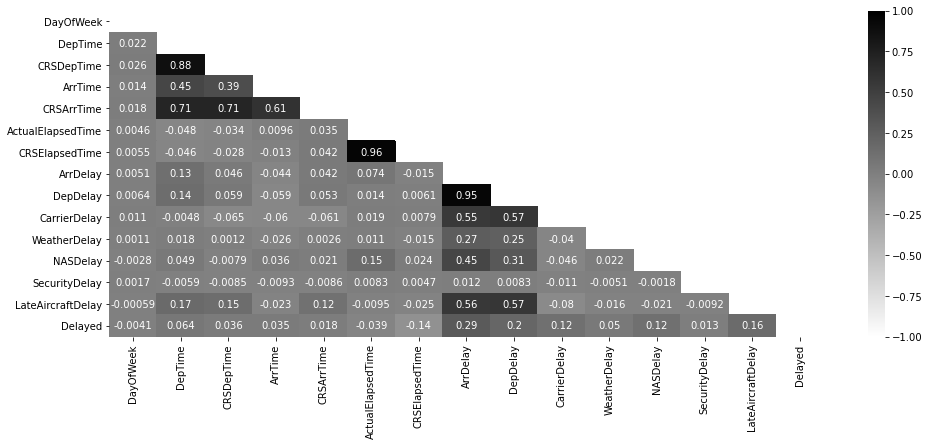

In [13]:
plt.figure(figsize=(16, 6))
sns.heatmap(df1.corr(), annot=True, cmap='gist_yarg', robust=True, vmin=-1, vmax=1, mask=np.triu(np.ones_like(df1.corr())));

Visualizing the relationship between ArrDelay and its correlated features   

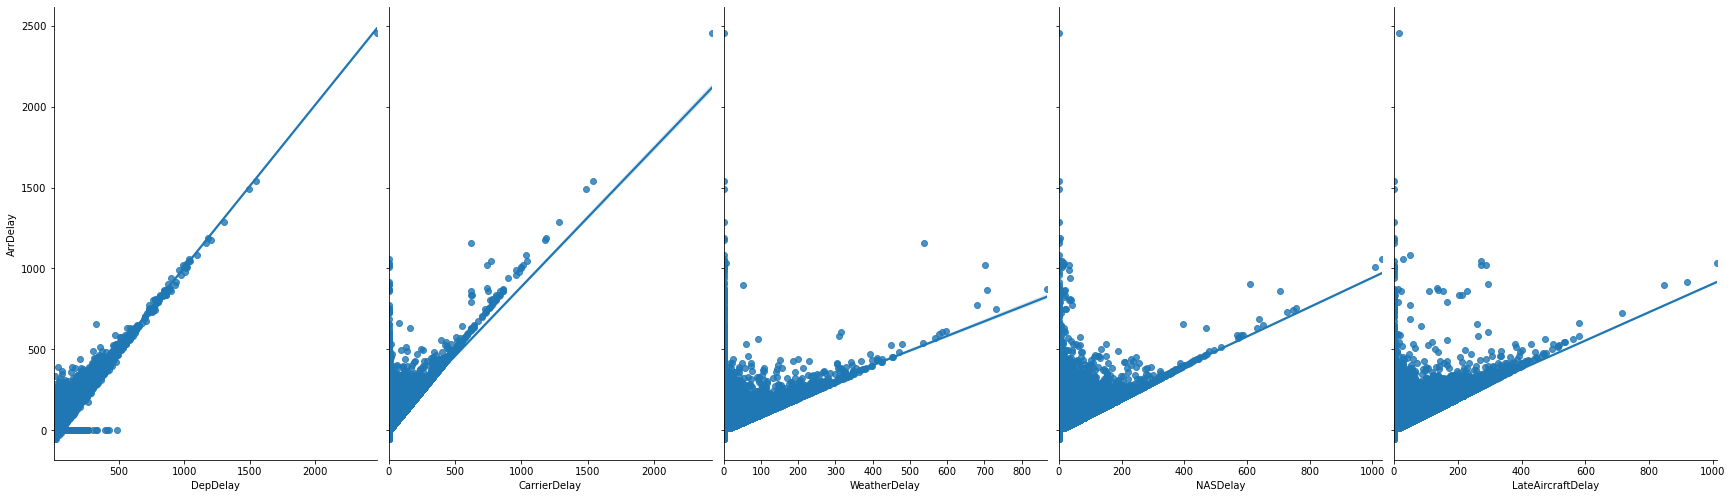

In [14]:
sns.pairplot(df1, x_vars=['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay'], y_vars='ArrDelay', height=7, aspect=0.7, kind='reg');

#### Feature Selection

Explanatory variables (X), and target variable (y)

In [15]:
feature_cols = ['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']
X = df1[feature_cols]
X.head(3)

,DepDelay,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay
1782417,10.0,71.0,0.0,0.0,0.0
512712,560.0,543.0,0.0,0.0,5.0
447137,21.0,0.0,0.0,0.0,0.0


In [16]:
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(193675, 5)


In [17]:
y = df1['Delayed']
y.head(3)

1782417    1
512712     1
447137     1
Name: Delayed, dtype: int64

In [18]:
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(193675,)


#### Train and Test split

Split X and y into training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(145256, 5)
(48419, 5)
(145256,)
(48419,)


#### Building and training the models

### Logistic Regression Classification

In [21]:
lgr = LogisticRegression()      # build
lgr = lgr.fit(X_train, y_train)  # train
y_pred_lgr = lgr.predict(X_test)  # make prediction
print("lgr Accuracy:", metrics.accuracy_score(y_test, y_pred_lgr)) 
print("lgr Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_lgr))
print("lgr F1 Score:", metrics.f1_score(y_test, y_pred_lgr))
print("lgr Cross Validation Scores:", cross_val_score(lgr, X, y, cv=5))

lgr Accuracy: 0.892211735062682
lgr Confusion Matrix:
 [[    0  5219]
 [    0 43200]]
lgr F1 Score: 0.9430358331787075
lgr Cross Validation Scores: [0.89084807 0.89084807 0.89084807 0.89084807 0.89084807]


In [22]:
# train the model with parameters
lgr = LogisticRegression(class_weight='balanced', solver='sag', random_state=42) 
lgr = lgr.fit(X_train, y_train) 
y_pred_lgr = lgr.predict(X_test) 
print("lgr Accuracy:", metrics.accuracy_score(y_test, y_pred_lgr)) 
print("lgr Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_lgr))
print("lgr F1 Score:", metrics.f1_score(y_test, y_pred_lgr))
print("lgr Cross Validation Scores:", cross_val_score(lgr, X, y, cv=5))

lgr Accuracy: 0.7547450381048761
lgr Confusion Matrix:
 [[ 5219     0]
 [11875 31325]]
lgr F1 Score: 0.8406574974840657
lgr Cross Validation Scores: [0.75167161 0.75502775 0.75673164 0.75404673 0.74921905]


### Decision Tree Classification 

In [23]:
dtree = DecisionTreeClassifier() 
dtree = dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)
print("dtree Accuracy:", metrics.accuracy_score(y_test, y_pred_dtree))
print("dtree Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_dtree))
print("dtree F1 Score:", metrics.f1_score(y_test, y_pred_dtree))
print("dtree Cross Validation Scores:", cross_val_score(dtree, X, y, cv=5))

dtree Accuracy: 0.8936367954728516
dtree Confusion Matrix:
 [[   80  5139]
 [   11 43189]]
dtree F1 Score: 0.9437330652914955
dtree Cross Validation Scores: [0.89247451 0.89239706 0.89234542 0.89193236 0.89229379]


In [24]:
# train the model with parameters
dtree = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=42, max_depth=3) 
dtree = dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)
print("dtree Accuracy:", metrics.accuracy_score(y_test, y_pred_dtree))
print("dtree Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_dtree))
print("dtree F1 Score:", metrics.f1_score(y_test, y_pred_dtree))
print("dtree Cross Validation Scores:", cross_val_score(dtree, X, y, cv=5))

dtree Accuracy: 0.892211735062682
dtree Confusion Matrix:
 [[    0  5219]
 [    0 43200]]
dtree F1 Score: 0.9430358331787075
dtree Cross Validation Scores: [0.89084807 0.89084807 0.89084807 0.89084807 0.89084807]


### Nearest Neighbors Classification

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("knn Accuracy:", metrics.accuracy_score(y_test, y_pred_knn))
print("knn Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_knn))
print("knn F1 Score:", metrics.f1_score(y_test, y_pred_knn))
print("knn Cross Validation Scores:", cross_val_score(knn, X, y, cv=5))

knn Accuracy: 0.8876267580908321
knn Confusion Matrix:
 [[ 1756  3463]
 [ 1978 41222]]
knn F1 Score: 0.9380895488422369
knn Cross Validation Scores: [0.87460953 0.88284497 0.87489351 0.85800955 0.87231186]


In [29]:
# train the model with parameters
knn = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("knn Accuracy:", metrics.accuracy_score(y_test, y_pred_knn))
print("knn Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_knn))
print("knn F1 Score:", metrics.f1_score(y_test, y_pred_knn))
print("knn Cross Validation Scores:", cross_val_score(knn, X, y, cv=5))

knn Accuracy: 0.8706499514653339
knn Confusion Matrix:
 [[ 2068  3151]
 [ 3112 40088]]
knn F1 Score: 0.9275442797811174
knn Cross Validation Scores: [0.88385181 0.88338712 0.86792307 0.85726088 0.88008261]


### Support Vector Machine Classification

In [31]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("svm Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))
print("svm Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_svm))
print("svm F1 Score:", metrics.f1_score(y_test, y_pred_svm))
print("Cross Validation Scores:", cross_val_score(svm, X, y, cv=5))

svm Accuracy: 0.8933269997315103
svm Confusion Matrix:
 [[   57  5162]
 [    3 43197]]
svm F1 Score: 0.9435882873338503
Cross Validation Scores: [0.89216471 0.89206144 0.89213889 0.89193236 0.89188073]


In [33]:
# train the model with parameters
svm = SVC(kernel='linear', C=1, random_state=42)  #, coef0=1.0
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("svm Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))
print("svm Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_svm))
print("svm F1 Score:", metrics.f1_score(y_test, y_pred_svm))
print("Cross Validation Scores:", cross_val_score(svm, X, y, cv=5))

svm Accuracy: 0.892211735062682
svm Confusion Matrix:
 [[    0  5219]
 [    0 43200]]
svm F1 Score: 0.9430358331787075
Cross Validation Scores: [0.89084807 0.89084807 0.89084807 0.89084807 0.89084807]


______________

Repositori: Supervisat_Classificacio